In [1]:
from datetime import datetime as dt 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
df = pd.read_csv(filepath_or_buffer='Building_Permits_Cleaned.csv', index_col=0)

In [3]:
lst = list(df[df.time_frame == 'unknown'].index)
df.drop(index=lst, inplace=True)

In [4]:
def to_category(columns, dataframe):
    """Convert a list of columns, from a dataframe, to a category datatype"""
    for column in columns: 
        dataframe[column] = dataframe[column].astype('category')

def to_integer(columns, dataframe):
    """Convert columns from a dataframe to an int64 datatype"""
    for column in columns: 
        dataframe[column] = dataframe[column].astype('int64')

In [5]:
cols = ['permit_type', 'description', 'current_status',
        'current_status_date', 'filed_date', 'issued_date', 'completed_date',
        'fire_only_permit', 'permit_expiration_date', 'revised_cost', 'proposed_use',
        'existing_use', 'plansets','tidf_compliance', 'existing_construction_type',
        'proposed_construction_type','site_permit', 'supervisor_district',
        'neighborhoods', 'zipcode', 'location','address', 'time_range', 'time_frame']
df.drop(columns=cols, inplace=True)

In [6]:
columns = ['permit_type_definition',
           'existing_construction_type_description',
           'proposed_construction_type_description',
           'decision', 'region', 'existing_use_category',
           'proposed_use_category']

to_category(columns=columns, dataframe=df)

Columns that need mean imputed: existing_stories, proposed_stories, estimated_cost, existing_units, proposed_units, latitude, longitude
Need to convert categories to code: permit_type_definition, existing_construction_type_description, proposed_construction_type_description, decision, region, existing_use_category, proposed_use_category

In [7]:
columns = ['permit_type_definition',
           'existing_construction_type_description',
           'proposed_construction_type_description',
           'region', 'existing_use_category',
           'proposed_use_category']
df = pd.get_dummies(data=df, columns=columns)

In [8]:
y = df.decision
X = df.drop(columns='decision')

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
imp = Imputer()
scaler = StandardScaler()
clf = LogisticRegression(multi_class='multinomial', solver='newton-cg')

pipeline = make_pipeline(imp, scaler)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
Xtrain_scaled = pipeline.fit_transform(Xtrain)
Xtest_scaled = pipeline.transform(Xtest)

In [12]:
param_grid = {'C':[0.001, 0.01, 0.1,1,10,100,1000, 2000, 3000, 5000]}

search = GridSearchCV(estimator=clf, param_grid=param_grid,
                      scoring='neg_log_loss', cv=5)

In [13]:
search.fit(Xtrain_scaled, ytrain)
search.best_params_

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


{'C': 100}

In [14]:
best_clf = LogisticRegression(C=100, multi_class='multinomial', solver='newton-cg')

In [15]:
best_clf.fit(Xtrain_scaled, ytrain)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
ypred = best_clf.predict(Xtest_scaled)

print("Training Accuracy: {}".format(best_clf.score(Xtrain_scaled, ytrain)))
print("Testing Accuracy: {}".format(best_clf.score(Xtest_scaled, ytest)))

Training Accuracy: 0.7343286216246571
Testing Accuracy: 0.7321085377373856


In [17]:
ypred_prob = best_clf.predict_proba(Xtest_scaled)

In [18]:
ytest = list(ytest)
ypred = list(ypred)
confusion_matrix = confusion_matrix(y_true=ytest, y_pred=ypred)

In [19]:
confusion_matrix

array([[    1,   498,   562],
       [    0, 34747,  2994],
       [    3, 12391, 10202]])

In [20]:
ytest = pd.Series(ytest)
ypred = pd.Series(ypred)
pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,denied,instant approval,non-instant approval,All
True,,,,
denied,1,498,562,1061
instant approval,0,34747,2994,37741
non-instant approval,3,12391,10202,22596
All,4,47636,13758,61398


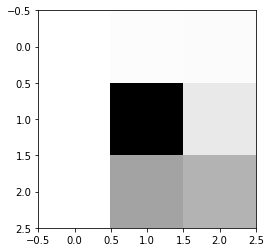

In [21]:
plt.imshow(confusion_matrix, cmap='binary', interpolation='None')
plt.show()

In [22]:
print(classification_report(ytest, ypred))

                      precision    recall  f1-score   support

              denied       0.25      0.00      0.00      1061
    instant approval       0.73      0.92      0.81     37741
non-instant approval       0.74      0.45      0.56     22596

         avg / total       0.73      0.73      0.71     61398



In [23]:
from sklearn.metrics import log_loss 

In [24]:
y = log_loss(y_true=ytest, y_pred=ypred_prob, labels=['denied', 'instant approval', 'non-instant approval'])
print(y)

0.5543596568507907


### Random Forest Classifier

In [25]:
rfc = RandomForestClassifier()

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 700, num = 25)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
param = {'n_estimators':n_estimators, 
         'max_depth':max_depth,
         'min_samples_split':min_samples_split,
         'min_samples_leaf':min_samples_leaf}

In [27]:
imp = Imputer()
Xtrain = imp.fit_transform(Xtrain)
Xtest = imp.transform(Xtest)

In [28]:
rscv = RandomizedSearchCV(estimator=rfc, param_distributions=param,
                                 n_iter=50, scoring='neg_log_loss', cv=5)

rscv.fit(Xtrain, ytrain)
rscv.best_params_

{'n_estimators': 643,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 70}

In [29]:
rfc = RandomForestClassifier(n_estimators=643, min_samples_split=2, min_samples_leaf=2, max_depth=70)
rfc.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=643, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
ypred = rfc.predict(Xtest)

In [31]:
print("Training Accuracy: {}".format(rfc.score(Xtrain, ytrain)))
print("Testing Accuracy: {}".format(rfc.score(Xtest, ytest)))

Training Accuracy: 0.8700723602932918
Testing Accuracy: 0.7849441349881103


In [32]:
print(classification_report(ytest, ypred))

                      precision    recall  f1-score   support

              denied       0.93      0.05      0.09      1061
    instant approval       0.79      0.90      0.84     37741
non-instant approval       0.76      0.63      0.69     22596

         avg / total       0.79      0.78      0.77     61398



In [33]:
ytest = pd.Series(ytest)
ypred = pd.Series(ypred)
pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,denied,instant approval,non-instant approval,All
True,,,,
denied,52,407,602,1061
instant approval,4,33906,3831,37741
non-instant approval,0,8360,14236,22596
All,56,42673,18669,61398


In [34]:
ypred_prob = rfc.predict_proba(Xtest)
y = log_loss(y_true=ytest, y_pred=ypred_prob, labels=['denied', 'instant approval', 'non-instant approval'])
print(y)

0.4865109550761814
